# Loan Default Risk

In [72]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import load_model

In [73]:
def plot_var(col_name, title, continuous, dataset, x1limit=False, x2limit=False, x1l=0, x1u=0, x2l=0, x2u=0):
    """
    Plot a variable against the response variable loan status
    - col_name is the variable name in the dataframe
    - title is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    - dataset is the pandas dataframe containing the dataset
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=90)

    # Plot without loan status
    if continuous:
        sns.distplot(dataset.loc[dataset[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(dataset[col_name], order=sorted(dataset[col_name].unique()),
                      color='#4f81bd', saturation=1, ax=ax1)
    if x1limit:
        ax1.set_xlim([x1l, x1u])
    ax1.set_xlabel(title)
    ax1.set_ylabel('Frequency')
    ax1.set_title(title)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=dataset, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(title + ' by Loan Status')
    else:
        charge_off_rates = dataset.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:, 'Default']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#4f81bd', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Default')
        ax2.set_title('Default Rate by ' + title)
    if x2limit:
        ax2.set_xlim([x2l, x2u])
    ax2.set_xlabel(title)

    plt.tight_layout()

# Preliminary Data Analysis

In [74]:
# read in the entire raw dataset
dataset = pd.read_csv(Path('../data/2017Half_clean.csv'), header=0)
pd.set_option('display.max_columns', None)
dataset.head()

,loan_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000,36 months,7.35%,155.19,A,5 years,MORTGAGE,60000.0,Not Verified,Fully Paid,car,15.76,0,Oct-04,12,0,3697,13.20%,25,w,Individual,1,0
1,7500,36 months,7.35%,232.79,A,7 years,MORTGAGE,110000.0,Not Verified,Fully Paid,debt_consolidation,13.12,0,Mar-13,19,0,23348,27.20%,27,w,Individual,4,0
2,9600,36 months,7.97%,300.70,A,< 1 year,OWN,140000.0,Not Verified,Fully Paid,credit_card,18.34,0,Aug-05,16,0,11808,48.60%,44,w,Individual,3,0
3,2000,36 months,7.07%,61.82,A,2 years,RENT,80000.0,Not Verified,Fully Paid,medical,12.15,0,Apr-05,9,0,38,0.30%,12,w,Individual,0,0
4,7200,36 months,24.85%,285.70,E,2 years,RENT,50000.0,Source Verified,Fully Paid,debt_consolidation,6.07,0,Jan-00,4,0,3560,98.90%,5,w,Individual,0,0


In [75]:
# Look at how many of each response variable we have
print(dataset['loan_status'].value_counts(dropna=False))
print(dataset['loan_status'].value_counts(normalize=True, dropna=False))
print(dataset.shape)

Fully Paid    29145
Default       18494
Name: loan_status, dtype: int64
Fully Paid    0.611789
Default       0.388211
Name: loan_status, dtype: float64
(47639, 23)


| Status     | Count | Percentage |
| -----------|:-----:|:----------:|
| Fully Paid | 29145 | 61% |
| Charged Off | 18494 | 39% |

47639 rows x 23 Columns

A list of percentage of missing values in a column

In [76]:
missing_values = ((dataset.isna().sum()) / len(dataset.index)).sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
print(missing_values*100)

emp_length    7.225173
revol_util    0.065073
dti           0.056676
dtype: float64


| Variable | % Missing |
| ---------|:----:|
| emp_length | 7.225173% |
| revol_util | 0.065073% |
| dti | 0.056676% |

In [77]:
# Look at the data type of each column
print(dataset.dtypes)

loan_amnt                 int64
term                     object
int_rate                 object
installment             float64
grade                    object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
loan_status              object
purpose                  object
dti                     float64
delinq_2yrs               int64
earliest_cr_line         object
open_acc                  int64
pub_rec                   int64
revol_bal                 int64
revol_util               object
total_acc                 int64
initial_list_status      object
application_type         object
mort_acc                  int64
pub_rec_bankruptcies      int64
dtype: object


| Variable | Type |
| ---------|:----:|
| Loan Amount | Numerical |
| Term | Categorical |
| Interest Rate | Numerical |
| Installment | Numerical |
| Grade | Categorical |
| Employment Length | Categorical |
| Home Ownership | Categorical |
| Annual Income | Numerical |
| Verification Status | Categorical |
| Loan Status| Categorical |
| Purpose | Categorical |
| Debt-to-Income Ratio | Numerical |
| Delinquency | Categorical |
| Earliest Credit Line | Numerical |
| Open Accounts | Numerical |
| Public Records | Categorical |
| Revolving Balance | Numerical |
| Revolving Utility | Numerical |
| Total Account | Numerical |
| Initial List Status | Categorical |
| Application Type | Categorical |
| Mortage Account | Numerical |
| Public Record of Bankruptcies | Categorical |

# Exploratory Data Analysis

### Annual Income (Numerical)
The self-reported annual income provided by the borrower during registration

               count          mean           std  min      25%      50%  \
loan_status                                                               
Default      18494.0  74073.439857  46806.677767  0.0  45000.0  64000.0   
Fully Paid   29145.0  80899.315013  69096.968024  0.0  49000.0  69000.0   

                 75%        max  
loan_status                      
Default      90000.0   982000.0  
Fully Paid   97133.0  5616890.0  
               count       mean       std  min        25%        50%  \
loan_status                                                            
Default      18494.0  11.058230  0.590522  0.0  10.714440  11.066654   
Fully Paid   29145.0  11.129532  0.625351  0.0  10.799596  11.141876   

                   75%        max  
loan_status                        
Default      11.407576  13.797348  
Fully Paid   11.483847  15.541289  


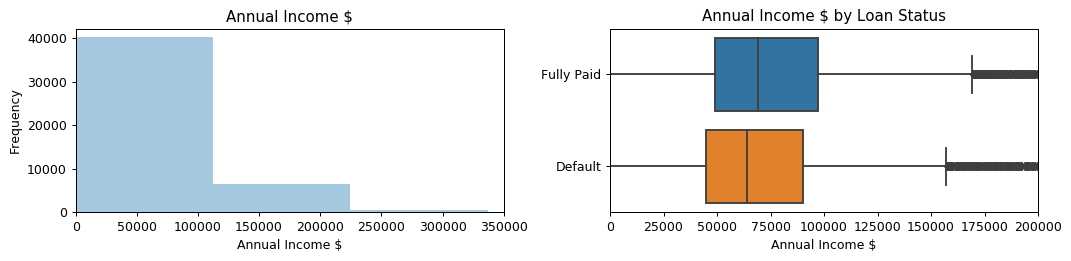

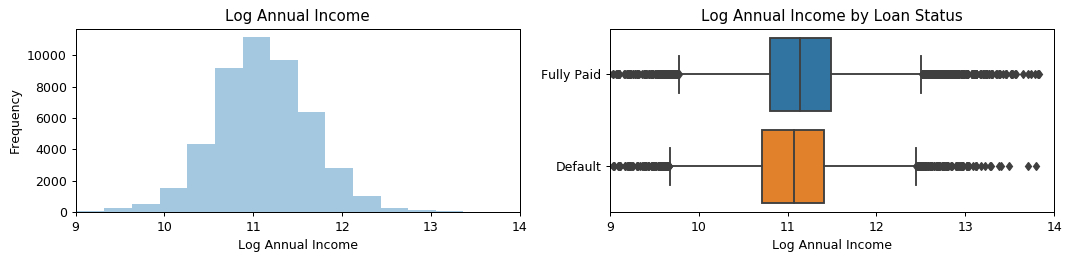

In [78]:
print(dataset.groupby('loan_status')['annual_inc'].describe())
plot_var('annual_inc', 'Annual Income $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=-1, x1u=350000, x2l=-1, x2u=200000)
# Because the plot is right skewed we take a log transform of the annual income
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log(x + 1))
dataset.drop('annual_inc', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_annual_inc'].describe())
plot_var('log_annual_inc', 'Log Annual Income', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=9, x1u=14, x2l=9, x2u=14)

It seems that those with higher annual income are less risk

### Application Type (Categorical)
Indicates whether the loan is an individual application or a joint application with two co-borrowers

loan_status  application_type
Default      Individual          17551
             Joint App             943
Fully Paid   Individual          27609
             Joint App            1536
Name: application_type, dtype: int64


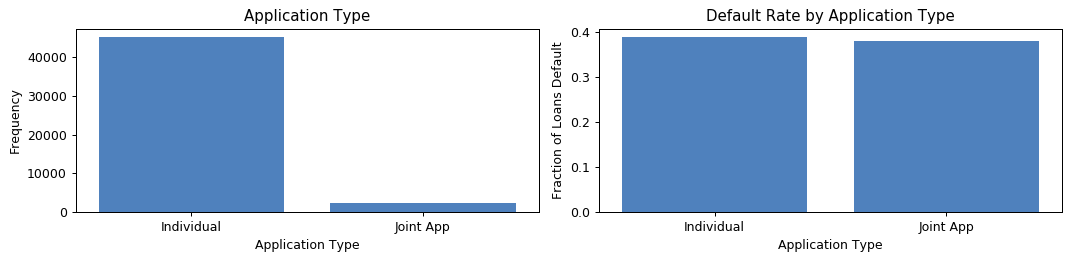

In [79]:
print(dataset.groupby('loan_status')['application_type'].value_counts(dropna=False))
plot_var('application_type', 'Application Type', continuous=False, dataset=dataset)

There does not seem to be a strong correlation between risk and application_type. Both risk around the same percentage.

### Debt to Income Ratio (Numerical)
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

               count       mean        std  min    25%    50%    75%     max
loan_status                                                                 
Default      18486.0  20.346391  12.928459  0.0  13.77  19.98  26.31  886.77
Fully Paid   29126.0  18.066659  13.751295  0.0  11.48  17.19  23.52  999.00


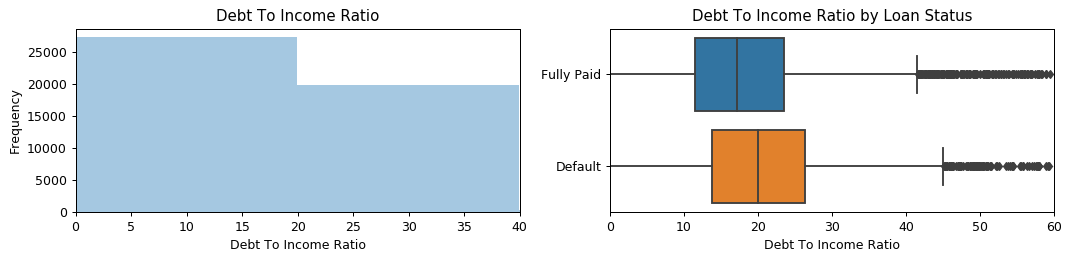

In [80]:
# dummy = dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti']
print(dataset.groupby('loan_status')['dti'].describe())
plot_var('dti', 'Debt To Income Ratio', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=60)
# sns.distplot(dataset.loc[dataset['dti'].notnull() & (dataset['dti']<60), 'dti'], kde=False)
# plt.xlabel('Debt-to-income Ratio')
# plt.ylabel('Count')
# plt.title('Debt-to-income Ratio')

It seems that a higher debt to income ratio has a higher probability of charged off

### Delinquency (Categorical)
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

loan_status  delinq_2yrs
Default      0              14465
             1               2587
             2               1442
Fully Paid   0              23444
             1               3817
             2               1884
Name: delinq_2yrs, dtype: int64


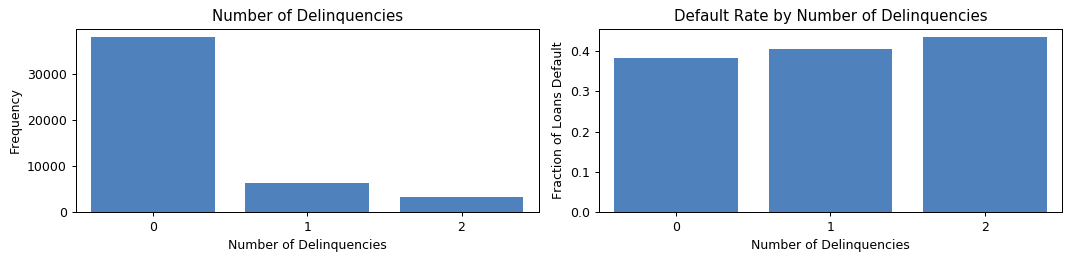

In [81]:
dataset['delinq_2yrs'].values[dataset['delinq_2yrs'] > 1] = 2
print(dataset.groupby('loan_status')['delinq_2yrs'].value_counts(dropna=False))
plot_var('delinq_2yrs', 'Number of Delinquencies', continuous=False, dataset=dataset)

There seems to be an increasing trend in charge-off rate and increasing number of delinquencies but it is small. Whether or not this is significant remains to be seen.

### Earliest Credit Line (Numerical)
The month the borrower's earliest reported credit line was opened.

               count         mean       std     min     25%     50%     75%  \
loan_status                                                                   
Default      18494.0  2000.799773  7.758312  1953.0  1997.0  2002.0  2006.0   
Fully Paid   29145.0  2000.470647  7.565745  1958.0  1997.0  2002.0  2005.0   

                max  
loan_status          
Default      2014.0  
Fully Paid   2014.0  


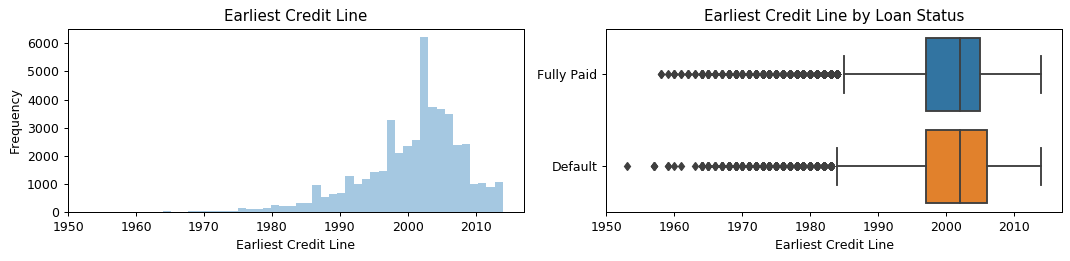

In [82]:
# dataset['earliest_cr_line'] = pd.to_datetime(dataset['earliest_cr_line'], format='%b-%y').dt.year
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-2:]))
dataset.loc[dataset['earliest_cr_line'] > 20, 'earliest_cr_line'] += 1900
dataset.loc[dataset['earliest_cr_line'] < 20, 'earliest_cr_line'] += 2000
print(dataset.groupby('loan_status')['earliest_cr_line'].describe())
plot_var('earliest_cr_line', 'Earliest Credit Line', continuous=True, dataset=dataset)

It seems that those with an earlier credit line are more likely to be less risk

### Employment Length (Categorical)
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

loan_status  emp_length
Default      0.0            1541
             1.0            1328
             2.0            1823
             3.0            1581
             4.0            1099
             5.0            1152
             6.0             732
             7.0             650
             8.0             582
             9.0             627
             10.0           5630
             NaN            1749
Fully Paid   0.0            2454
             1.0            1879
             2.0            2654
             3.0            2349
             4.0            1793
             5.0            1788
             6.0            1311
             7.0            1054
             8.0             856
             9.0            1101
             10.0          10213
             NaN            1693
Name: emp_length, dtype: int64


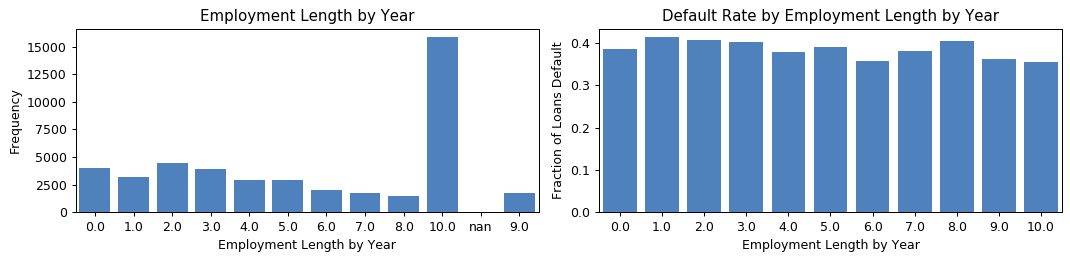

In [83]:
dataset['emp_length'].replace('< 1 year', 0, inplace=True)
dataset['emp_length'].replace('1 year', 1, inplace=True)
dataset['emp_length'].replace('2 years', 2, inplace=True)
dataset['emp_length'].replace('3 years', 3, inplace=True)
dataset['emp_length'].replace('4 years', 4, inplace=True)
dataset['emp_length'].replace('5 years', 5, inplace=True)
dataset['emp_length'].replace('6 years', 6, inplace=True)
dataset['emp_length'].replace('7 years', 7, inplace=True)
dataset['emp_length'].replace('8 years', 8, inplace=True)
dataset['emp_length'].replace('9 years', 9, inplace=True)
dataset['emp_length'].replace('10+ years', 10, inplace=True)
print(dataset.groupby('loan_status')['emp_length'].value_counts(dropna=False).sort_index())
plot_var('emp_length', 'Employment Length by Year', continuous=False, dataset=dataset)

Doesn't seem to be much of a significant pattern here

### Home Ownership (Categorical)
The home ownership status provided by the borrower during registration or obtained from the credit report.

loan_status  home_ownership
Default      RENT               8466
             MORTGAGE           7816
             OWN                2212
Fully Paid   MORTGAGE          15653
             RENT              10147
             OWN                3345
Name: home_ownership, dtype: int64


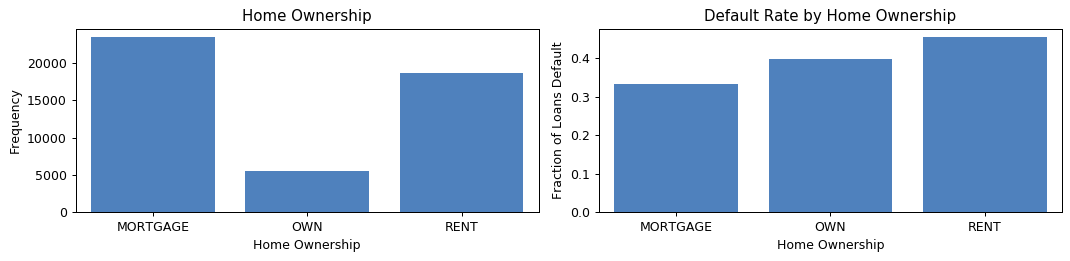

In [84]:
# dataset['home_ownership'].replace(['NONE', 'ANY'], 'NaN', inplace=True)
dataset['home_ownership'].replace(['NONE', 'ANY'], 'MORTGAGE', inplace=True)
print(dataset.groupby('loan_status')['home_ownership'].value_counts(dropna=False))
plot_var('home_ownership', 'Home Ownership', continuous=False, dataset=dataset)
# dataset['home_ownership'].replace('NaN', np.nan, inplace=True)

Interestingly those with a mortgage are more likely to pay off loans and those who rent are the least likely

### Initial List Status (Categorical)
The initial listing status of the loan. Possible values are – W, F

loan_status  initial_list_status
Default      w                      12515
             f                       5979
Fully Paid   w                      21390
             f                       7755
Name: initial_list_status, dtype: int64


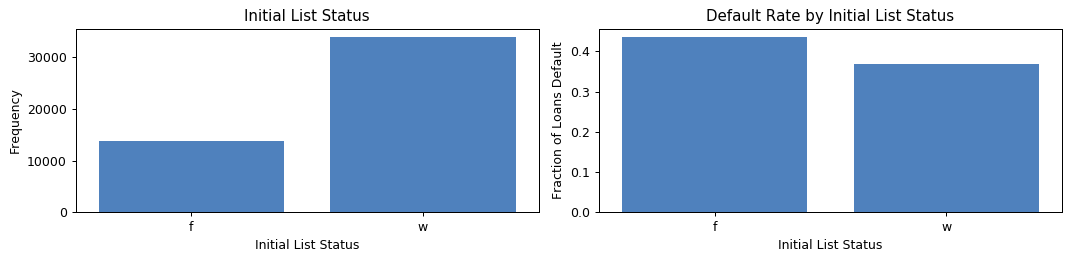

In [85]:
print(dataset.groupby('loan_status')['initial_list_status'].value_counts(dropna=False))
plot_var('initial_list_status', 'Initial List Status', continuous=False, dataset=dataset)

Theres does not seem to be much information gained from Initial List status

### Installment (Numerical)
The monthly payment owed by the borrower if the loan originates.

               count        mean         std    min     25%     50%     75%  \
loan_status                                                                   
Default      18494.0  490.309022  298.855772  30.99  271.45  410.35  659.43   
Fully Paid   29145.0  420.773546  281.422908  30.12  212.75  341.41  559.44   

                 max  
loan_status           
Default      1566.80  
Fully Paid   1587.23  
               count      mean       std       min       25%       50%  \
loan_status                                                              
Default      18494.0  5.995530  0.676362  3.465423  5.607455  6.019444   
Fully Paid   29145.0  5.811583  0.722315  3.437851  5.364807  5.836009   

                  75%       max  
loan_status                      
Default      6.492891  7.357429  
Fully Paid   6.328722  7.370375  


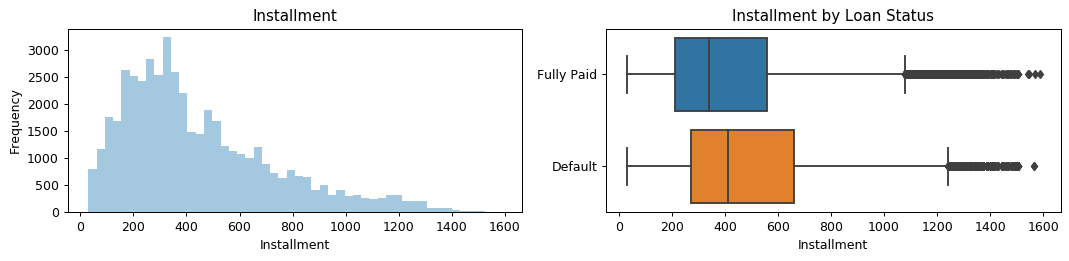

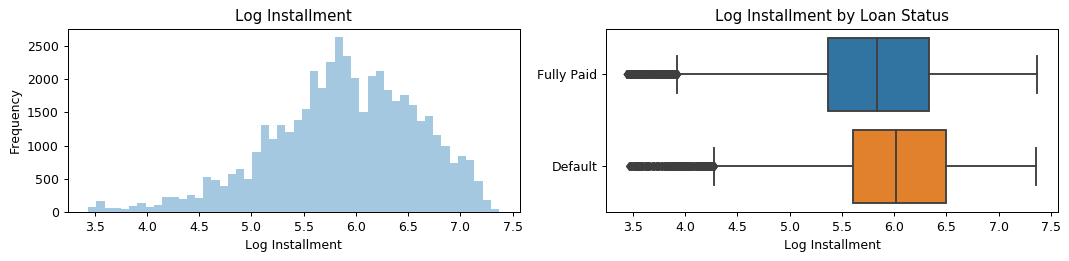

In [86]:
print(dataset.groupby('loan_status')['installment'].describe())
plot_var('installment', 'Installment', continuous=True, dataset=dataset)
# since the plot is left skewed, we take the log transformation
dataset['log_installment'] = dataset['installment'].apply(lambda x: np.log(x + 1))
dataset.drop('installment', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_installment'].describe())
plot_var('log_installment', 'Log Installment', continuous=True, dataset=dataset)

It seems those with higher installments are more likely to be charged off

### Interest Rate (Numerical)
Interest Rate on the loan

               count       mean       std   min    25%    50%    75%    max
loan_status                                                                
Default      18494.0  16.556265  5.858256  5.32  12.74  15.05  18.99  30.99
Fully Paid   29145.0  13.215077  5.276465  5.32   9.93  12.62  15.99  30.99


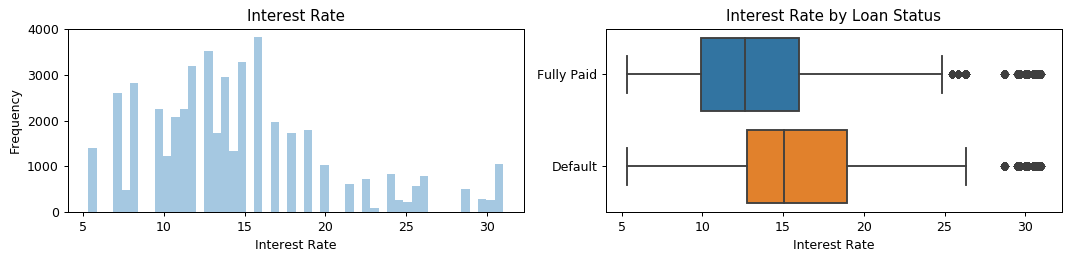

In [87]:
dataset['int_rate'] = dataset['int_rate'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['int_rate'].describe())
plot_var('int_rate', 'Interest Rate', continuous=True, dataset=dataset)

There seems to be a much higher interest rate on average for loans that charge off

### Loan Amount (Numerical)
The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

               count          mean          std     min     25%      50%  \
loan_status                                                                
Default      18494.0  15645.820266  9411.036948  1000.0  8000.0  14000.0   
Fully Paid   29145.0  13690.972723  9244.813927  1000.0  6400.0  11200.0   

                 75%      max  
loan_status                    
Default      21000.0  40000.0  
Fully Paid   19200.0  40000.0  


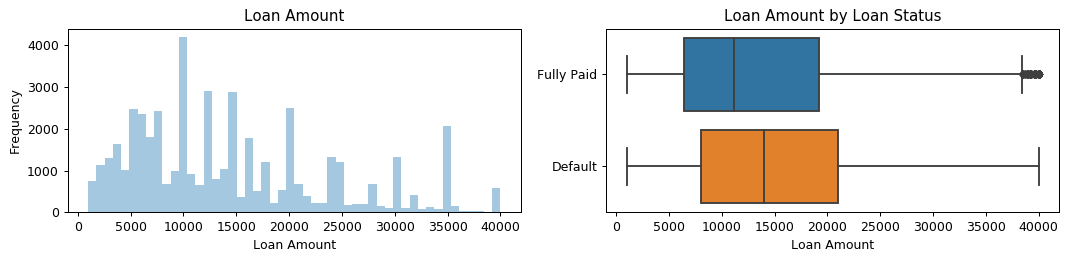

In [88]:
print(dataset.groupby('loan_status')['loan_amnt'].describe())
plot_var('loan_amnt', 'Loan Amount', continuous=True, dataset=dataset)

It seems charged off loans have a higher loan amount

### Mortgage Accounts (Numerical)
Number of mortgage accounts

loan_status  mort_acc
Default      0            9093
             1            3457
             2            2514
             3            1639
             4             914
             5             475
             6             216
             7             100
             8              42
             9              28
             10             16
Fully Paid   0           11003
             1            5592
             2            4767
             3            3288
             4            2163
             5            1118
             6             608
             7             290
             8             171
             10             80
             9              65
Name: mort_acc, dtype: int64


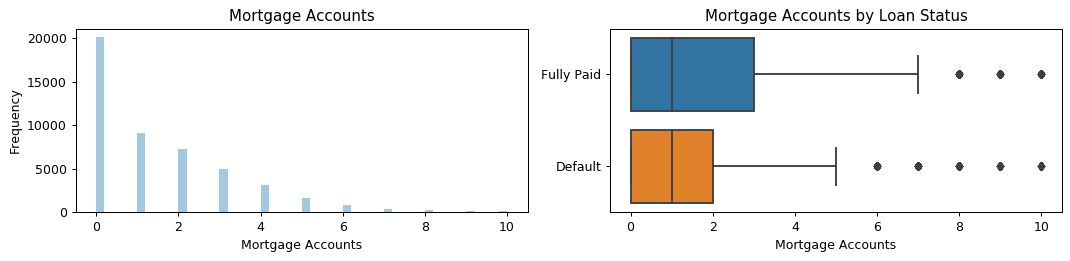

In [89]:
dataset.loc[dataset['mort_acc'] > 9, 'mort_acc'] = 10
print(dataset.groupby('loan_status')['mort_acc'].value_counts(dropna=False))
plot_var('mort_acc', 'Mortgage Accounts', continuous=True, dataset=dataset)

Currently there does not seem to be a significant difference

### Open Account (Numerical)
The number of open credit lines in the borrower's credit file.

               count       mean       std  min  25%   50%   75%   max
loan_status                                                          
Default      18494.0  11.944306  5.770755  1.0  8.0  11.0  15.0  68.0
Fully Paid   29145.0  11.825630  5.743959  0.0  8.0  11.0  15.0  88.0


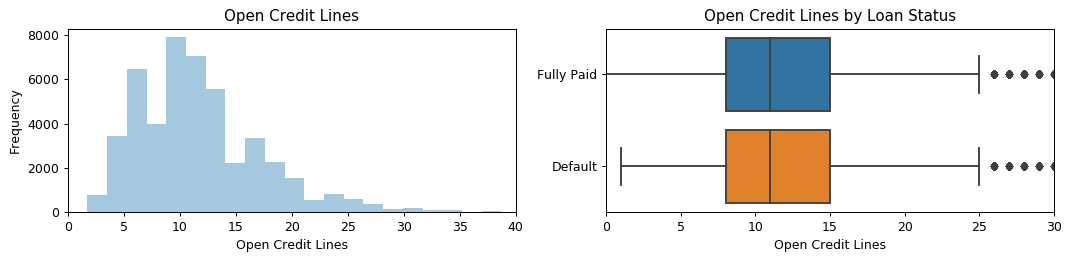

In [90]:
print(dataset.groupby('loan_status')['open_acc'].describe())
plot_var('open_acc', 'Open Credit Lines', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=40, x2l=0, x2u=30)

Does not seem to be a good indicator of risk

### Public Record (Categorical)
Number of derogatory public records

loan_status  pub_rec     
Default      None            14254
             At least one     4240
Fully Paid   None            22937
             At least one     6208
Name: pub_rec, dtype: int64


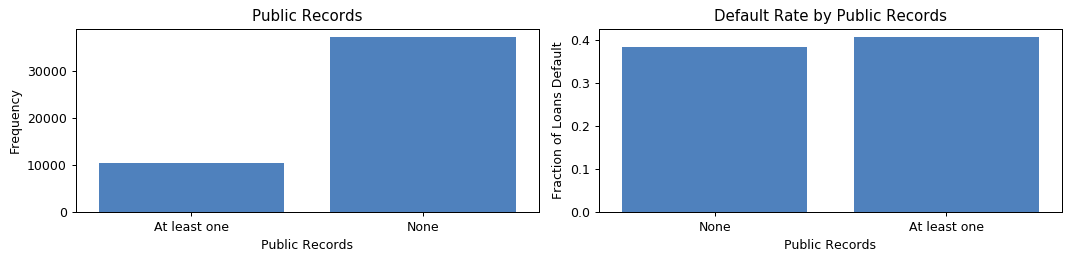

In [91]:
dataset['pub_rec'] = pd.cut(dataset['pub_rec'], [0, 0.9, 25], labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec'].value_counts(dropna=False))
plot_var('pub_rec', 'Public Records', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by derogatory public records

### Public Record of Bankruptcies (Categorical)
Number of public record bankruptcies

loan_status  pub_rec_bankruptcies
Default      None                    15508
             At least one             2986
Fully Paid   None                    24732
             At least one             4413
Name: pub_rec_bankruptcies, dtype: int64


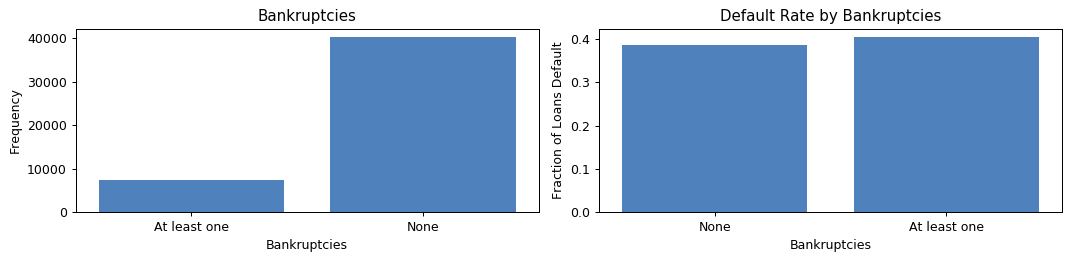

In [92]:
dataset['pub_rec_bankruptcies'] = pd.cut(dataset['pub_rec_bankruptcies'], [0, 0.9, 25], 
                                         labels=['None', 'At least one'], include_lowest=True)
print(dataset.groupby('loan_status')['pub_rec_bankruptcies'].value_counts(dropna=False))
plot_var('pub_rec_bankruptcies', 'Bankruptcies', continuous=False, dataset=dataset)

Loan default rate does not seem to change much by public bankruptcies records

### Purpose (Categorical)
A category provided by the borrower for the loan request

In [93]:
dataset.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:, 'Default'].sort_values()

purpose
car                   0.294828
home_improvement      0.323486
vacation              0.330827
house                 0.337255
major_purchase        0.351542
credit_card           0.368047
other                 0.397081
debt_consolidation    0.403409
moving                0.415217
renewable_energy      0.419355
medical               0.420624
small_business        0.577143
Name: loan_status, dtype: float64

### Revolving Balance (Numerical)
Total credit revolving balance

               count          mean           std  min      25%      50%  \
loan_status                                                               
Default      18494.0  15708.679734  17434.382178  0.0  6293.25  11532.0   
Fully Paid   29145.0  15601.315080  24339.574929  0.0  5176.00  10103.0   

                  75%        max  
loan_status                       
Default      19428.75   354794.0  
Fully Paid   18214.00  1039013.0  
               count      mean       std  min       25%       50%       75%  \
loan_status                                                                   
Default      18494.0  9.226252  1.132146  0.0  8.747392  9.352968  9.874561   
Fully Paid   29145.0  9.078444  1.308805  0.0  8.551981  9.220687  9.810001   

                   max  
loan_status             
Default      12.779295  
Fully Paid   13.853783  


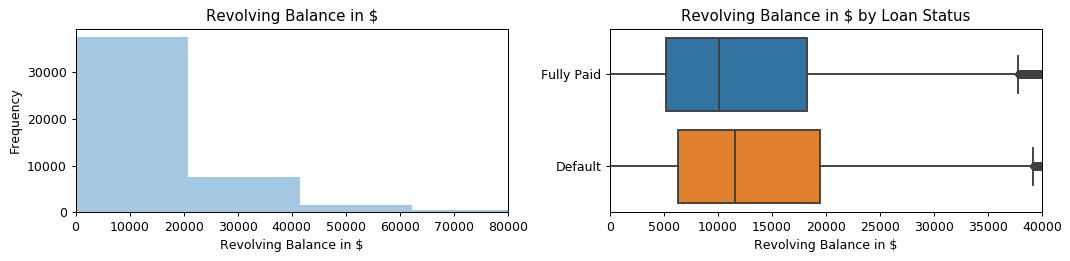

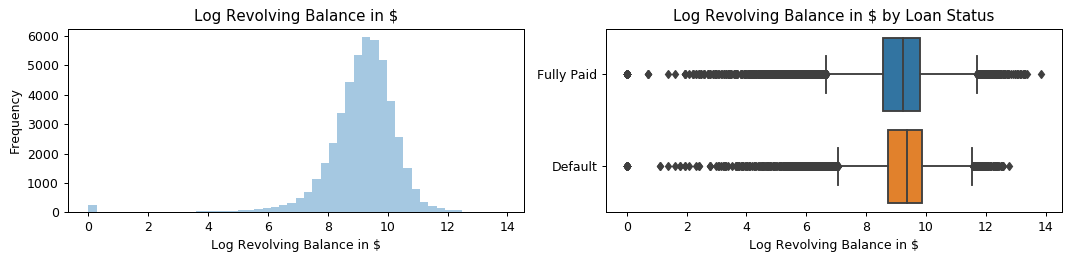

In [94]:
print(dataset.groupby('loan_status')['revol_bal'].describe())
plot_var('revol_bal', 'Revolving Balance in $', continuous=True, dataset=dataset,
         x1limit=True, x2limit=True, x1l=0, x1u=80000, x2l=0, x2u=40000)
# Seems like the data is heavily right skewed with a large range due to large outliers so we take the log transformation
dataset['log_revol_bal'] = dataset['revol_bal'].apply(lambda x: np.log(x + 1))
dataset.drop('revol_bal', axis=1, inplace=True)
print(dataset.groupby('loan_status')['log_revol_bal'].describe())
plot_var('log_revol_bal', 'Log Revolving Balance in $', continuous=True, dataset=dataset)

There is not much difference in the two categories for revolving balances

### Revolving Utility (Numerical)
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Default      18488.0  52.649946  23.650179  0.0  35.3  52.9  70.3  138.9
Fully Paid   29120.0  44.685968  24.521824  0.0  25.4  43.3  62.9  125.2


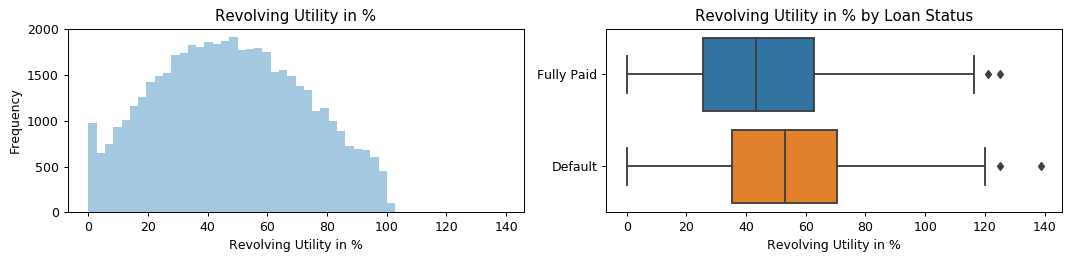

In [95]:
dataset['revol_util'] = dataset['revol_util'].str.rstrip('%').astype('float')
print(dataset.groupby('loan_status')['revol_util'].describe())
plot_var('revol_util', 'Revolving Utility in %', continuous=True, dataset=dataset)

It seems those with a lower revolving utility are more likely to pay off their loans

### Grade (Categorical)
LendingClub assigned loan grade. The higher the letter, the safer the loan.

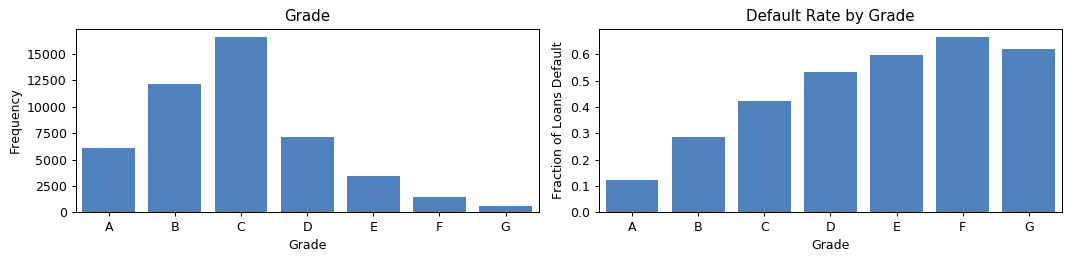

In [96]:
plot_var('grade', 'Grade', continuous=False, dataset=dataset)

There seems to be a strong trend between charge off rate and deteriorating grade

### Term (Categorical)
The number of payments on the loan. Values are in months and can be either 36 or 60

loan_status  term
Default      36      12599
             60       5895
Fully Paid   36      23073
             60       6072
Name: term, dtype: int64


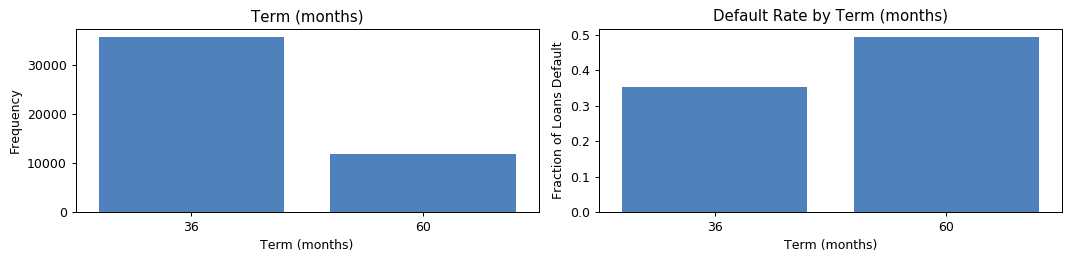

In [97]:
# dataset['term'].replace('36 months', 36, inplace=True)
# dataset['term'].replace('60 months', 60, inplace=True)
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))
print(dataset.groupby('loan_status')['term'].value_counts(dropna=False))
plot_var('term', 'Term (months)', continuous=False, dataset=dataset)

It seems longer term loans have a higher likelihood of being charged off

### Total Accounts (Numerical)
The total number of credit lines currently in the borrower's credit file

               count       mean        std  min   25%   50%   75%    max
loan_status                                                             
Default      18494.0  23.766843  11.858529  2.0  15.0  22.0  30.0  121.0
Fully Paid   29145.0  24.859633  12.233984  2.0  16.0  23.0  31.0  146.0


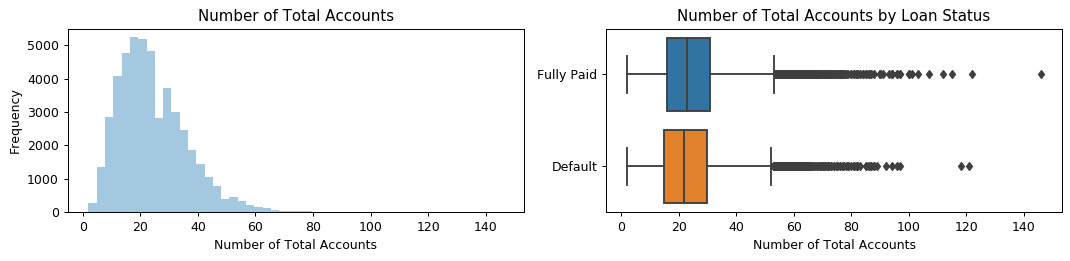

In [98]:
print(dataset.groupby('loan_status')['total_acc'].describe())
plot_var('total_acc', 'Number of Total Accounts', continuous=True, dataset=dataset)

There does not seem to be a significant difference in charge off rate depending on the total account number

### Verification Status (Categorical)
Indicates if income was verified, not verified, or if the income source was verified.

loan_status  verification_status
Default      Source Verified         7559
             Verified                6761
             Not Verified            4174
Fully Paid   Source Verified        11607
             Not Verified           10330
             Verified                7208
Name: verification_status, dtype: int64


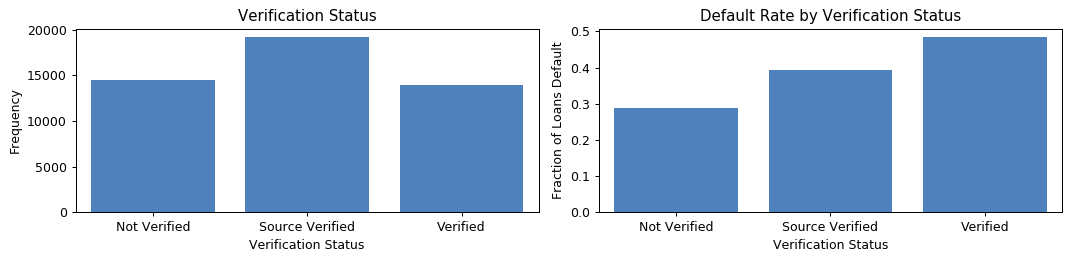

In [99]:
print(dataset.groupby('loan_status')['verification_status'].value_counts(dropna=False))
plot_var('verification_status', 'Verification Status', continuous=False, dataset=dataset)

There seems to be a strong linear trend between charged off rate and verification status. Surprisingly, loans with a status of verified have a higher chance of becoming charged off.

# Preliminary Model Design

### Create dummy variables
1 means charged-off and 0 means fully paid and create dummy variables for all categorical variables

In [100]:
dataset['loan_status'].replace('Default', 1, inplace=True)
dataset['loan_status'].replace('Fully Paid', 0, inplace=True)

dataset = pd.get_dummies(dataset, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 
                                           'initial_list_status', 'application_type', 'pub_rec', 
                                           'pub_rec_bankruptcies'], drop_first=True)
dataset.head()

,loan_amnt,term,int_rate,emp_length,loan_status,dti,delinq_2yrs,earliest_cr_line,open_acc,revol_util,total_acc,mort_acc,log_annual_inc,log_installment,log_revol_bal,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,initial_list_status_w,application_type_Joint App,pub_rec_At least one,pub_rec_bankruptcies_At least one
0,5000,36,7.35,5.0,0,15.76,0,2004,12,13.2,25,1,11.002117,5.051073,8.215547,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7500,36,7.35,7.0,0,13.12,0,2013,19,27.2,27,4,11.608245,5.454423,10.058309,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,9600,36,7.97,0.0,0,18.34,0,2005,16,48.6,44,3,11.849405,5.709433,9.376617,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2000,36,7.07,2.0,0,12.15,0,2005,9,0.3,12,0,11.289794,4.140273,3.663562,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,7200,36,24.85,2.0,0,6.07,0,2000,4,98.9,5,0,10.819798,5.658436,8.177797,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


### Split the data

In [101]:
dataset.dropna(inplace=True)
# dataset.fillna(lambda x: x.median())
y = dataset.loc[:, dataset.columns == 'loan_status']
x = dataset.loc[:, dataset.columns != 'loan_status']
# y = dataset['loan_status']
# X = dataset.drop(columns=['loan_status'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, 
                                                    stratify=dataset['loan_status'])
# x_train = x_train.reset_index()
# y_train = y_train.reset_index()

# Feature Selection and Model Fitting

### Logistic Regression Model

In [102]:
model_lr = LogisticRegression(penalty="l2", 
                              C=0.5, 
                              fit_intercept=True, 
                              class_weight='balanced', 
                              random_state=0, 
                              max_iter=10000, 
                              solver='lbfgs')
model_lr = model_lr.fit(x_train, y_train.values.ravel())
y_pred_lr = model_lr.predict(x_test)
# df_coefs = pd.DataFrame(model.coef_[0], index=x.columns, columns = ['Coefficient'])
# df_coefs

In [103]:
print("Accuracy: %.2f%%" % (model_lr.score(x_test, y_test) * 100))
confusion_matrix(y_test, y_pred_lr)

Accuracy: 64.50%


array([[5405, 2824],
       [1880, 3142]], dtype=int64)

In [104]:
import statsmodels.api as sm
logit_model = sm.Logit(y, x)
result = logit_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.593109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Logit
===================================================================================
Model:                    Logit                  Pseudo R-squared:       0.106     
Dependent Variable:       loan_status            AIC:                    52469.7036
Date:                     2019-07-25 13:46       BIC:                    52808.8372
No. Observations:         44167                  Log-Likelihood:         -26196.   
Df Model:                 38                     LL-Null:                -29308.   
Df Residuals:             44128                  LLR p-value:            0.0000    
Converged:                1.0000                 Scale:                  1.0000    
No. Iterations:           6.0000                                                   
-----------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------
loan_amnt                           -0.0000   0.0000 -2.1447 0.0320 -0.0000 -0.0000
term                                 0.0141   0.0013 10.8372 0.0000  0.0115  0.0166
int_rate                             0.0097   0.0091  1.0693 0.2849 -0.0081  0.0275
emp_length                          -0.0119   0.0029 -4.0620 0.0000 -0.0176 -0.0062
dti                                  0.0116   0.0014  8.5047 0.0000  0.0089  0.0143
delinq_2yrs                          0.1473   0.0181  8.1428 0.0000  0.1118  0.1827
earliest_cr_line                    -0.0019   0.0002 -9.7704 0.0000 -0.0022 -0.0015
open_acc                             0.0244   0.0029  8.5558 0.0000  0.0188  0.0300
revol_util                           0.0086   0.0006 15.1312 0.0000  0.0075  0.0098
total_acc                           -0.0080   0.0014 -5.8516 0.0000 -0.0107 -0.0053
mort_acc                            -0.0799   0.0081 -9.8922 0.0000 -0.0957 -0.0641
log_annual_inc                      -0.1578   0.0278 -5.6769 0.0000 -0.2123 -0.1033
log_installment                      0.4319   0.0405 10.6680 0.0000  0.3526  0.5113
log_revol_bal                       -0.0277   0.0125 -2.2205 0.0264 -0.0521 -0.0032
grade_B                              0.7118   0.0571 12.4607 0.0000  0.5998  0.8238
grade_C                              1.0898   0.0791 13.7817 0.0000  0.9348  1.2448
grade_D                              1.3184   0.1140 11.5632 0.0000  1.0949  1.5418
grade_E                              1.4086   0.1664  8.4630 0.0000  1.0824  1.7349
grade_F                              1.4722   0.2144  6.8651 0.0000  1.0519  1.8925
grade_G                              1.1873   0.2333  5.0900 0.0000  0.7301  1.6445
home_ownership_OWN                   0.1647   0.0363  4.5427 0.0000  0.0936  0.2358
home_ownership_RENT                  0.3616   0.0270 13.3728 0.0000  0.3086  0.4146
verification_status_Source Verified  0.2497   0.0270  9.2583 0.0000  0.1968  0.3026
verification_status_Verified         0.3870   0.0298 12.9815 0.0000  0.3285  0.4454
purpose_credit_card                  0.1081   0.1079  1.0014 0.3166 -0.1035  0.3196
purpose_debt_consolidation           0.0823   0.1059  0.7777 0.4368 -0.1252  0.2898
purpose_home_improvement             0.2263   0.1116  2.0281 0.0426  0.0076  0.4450
purpose_house                       -0.3497   0.1840 -1.9011 0.0573 -0.7103  0.0108
purpose_major_purchase               0.2294   0.1257  1.8241 0.0681 -0.0171  0.4758
purpose_medical                      0.4077   0.1356  3.0054 0.0027  0.1418  0.6736
purpose_moving                       0.2171   0.1493  1.4542 0.1459 -0.0755  0.5097
purpose_other                        0.2888   0.1120  2.5783 0.0099  0.0693  0.5084
purpose_renewable_energy             0.5985   0.4225  1.4166 0.1566 -0.2296  1.4265
purpose_small_business               0.8556   0.1427  5.9975 0.0000  0.5760  1.1352
purpose_vacation                     0

We remove all variables with p-value less than 0.05

In [105]:
result.pvalues[result.pvalues > 0.05]

int_rate                             0.284927
purpose_credit_card                  0.316646
purpose_debt_consolidation           0.436757
purpose_house                        0.057285
purpose_major_purchase               0.068132
purpose_moving                       0.145901
purpose_renewable_energy             0.156607
pub_rec_At least one                 0.188533
pub_rec_bankruptcies_At least one    0.507311
dtype: float64

In [106]:
keep_list = list(result.pvalues[result.pvalues < 0.05].index)
keep_list.append('loan_status')
drop_list = [col for col in dataset.columns if col not in keep_list]
x_train_lr = x_train.drop(labels=drop_list, axis=1)
x_test_lr = x_test.drop(labels=drop_list, axis=1)
model_lr2 = LogisticRegression(penalty="l2", C=0.5, fit_intercept=True, class_weight='balanced',
                               random_state=0, max_iter=10000, solver='lbfgs')
model_lr2 = model_lr2.fit(x_train_lr, y_train.values.ravel())
y_pred_lr = model_lr2.predict(x_test_lr)

### Logistic Regression Results

In [107]:
print("Accuracy: %.2f%%" % (model_lr2.score(x_test_lr, y_test) * 100))
confusion_matrix(y_test, y_pred_lr)

Accuracy: 62.59%


array([[5129, 3100],
       [1857, 3165]], dtype=int64)

In [108]:
print('F1 Score:', f1_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

F1 Score: 0.5608221848143884
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      8229
           1       0.51      0.63      0.56      5022

    accuracy                           0.63     13251
   macro avg       0.62      0.63      0.62     13251
weighted avg       0.65      0.63      0.63     13251



### Random Forest Model

In [109]:
model_rf_path = Path('../data/rf_1000.joblib')
if os.path.exists(model_rf_path):
    model_rf = load(model_rf_path)
else:
    n_trees = [50, 100, 250, 500, 1000, 1500, 2500]
    rf_dict = dict.fromkeys(n_trees)
    for num in n_trees:
        print(num)
        rf = RandomForestClassifier(n_estimators=num,
                                    min_samples_leaf=30,
                                    oob_score=True,
                                    random_state=100,
                                    class_weight='balanced',
                                    n_jobs=-1)
        rf.fit(x_train, y_train.values.ravel())
        rf_dict[num] = rf

    oob_error_list = [None] * len(n_trees)

    for i in range(len(n_trees)):
        oob_error_list[i] = 1 - rf_dict[n_trees[i]].oob_score_

    plt.plot(n_trees, oob_error_list, 'bo', n_trees, oob_error_list, 'k')
    # Save model to file
    dump(rf_dict[1000], model_rf_path)
    model_rf = rf_dict[1000]
y_pred_rf = model_rf.predict(x_test)

### Random Forest Results

In [110]:
print("Accuracy: %.2f%%" % (model_rf.score(x_test, y_test) * 100))
confusion_matrix(y_test, y_pred_rf)

Accuracy: 65.45%


array([[5241, 2988],
       [1590, 3432]], dtype=int64)

In [111]:
print('F1 Score:', f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

F1 Score: 0.5998951232302046
              precision    recall  f1-score   support

           0       0.77      0.64      0.70      8229
           1       0.53      0.68      0.60      5022

    accuracy                           0.65     13251
   macro avg       0.65      0.66      0.65     13251
weighted avg       0.68      0.65      0.66     13251



In [112]:
feature_list = list(x.columns)
# Get numerical feature importances
importances = list(model_rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: int_rate             Importance: 0.3
Variable: revol_util           Importance: 0.09
Variable: dti                  Importance: 0.07
Variable: log_installment      Importance: 0.07
Variable: loan_amnt            Importance: 0.05
Variable: mort_acc             Importance: 0.04
Variable: log_annual_inc       Importance: 0.04
Variable: log_revol_bal        Importance: 0.04
Variable: term                 Importance: 0.03
Variable: total_acc            Importance: 0.03
Variable: grade_B              Importance: 0.03
Variable: home_ownership_RENT  Importance: 0.03
Variable: emp_length           Importance: 0.02
Variable: earliest_cr_line     Importance: 0.02
Variable: open_acc             Importance: 0.02
Variable: grade_C              Importance: 0.02
Variable: grade_D              Importance: 0.02
Variable: grade_E              Importance: 0.02
Variable: verification_status_Verified Importance: 0.02
Variable: delinq_2yrs          Importance: 0.01
Variable: grade_F              Im

In [113]:
# New random forest with only >= 0.05 important variables
model_rf_i = RandomForestClassifier(n_estimators=1000,
                                           min_samples_leaf=30,
                                           oob_score=True,
                                           random_state=100,
                                           class_weight='balanced',
                                           n_jobs=-1)
# Extract the important features
important_indices = ['int_rate', 
                     'revol_util',
                     'dti',
                     'log_installment', 
                     'loan_amnt', 
                     'mort_acc', 
                     'log_annual_inc', 
                     'log_revol_bal']
x_train_i = x_train.loc[:, important_indices]
x_test_i = x_test.loc[:, important_indices]
# Train the random forest
model_rf_i.fit(x_train_i, y_train.values.ravel())
# Make predictions and determine the error
y_pred_rf_i = model_rf_i.predict(x_test_i)
print("Accuracy: %.2f%%" % (model_rf_i.score(x_test_i, y_test) * 100))
print(confusion_matrix(y_test, y_pred_rf_i))

Accuracy: 65.13%
[[5177 3052]
 [1568 3454]]


### Neural Network Model

In [114]:
scaler = StandardScaler()
scaler.fit(x_train.astype('float64'))
StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_nn = scaler.transform(x_train.astype('float64'))
x_test_nn = scaler.transform(x_test.astype('float64'))
dump(scaler, Path('../data/scaler.joblib'))

class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train.values.ravel()), 
                                                  y_train.values.ravel())

model_nn_path = Path('../data/model_nn.h5')
if os.path.exists(model_nn_path):
    model_nn = load_model(str(model_nn_path))
else:
    model_nn = Sequential()
    # Input layer
    model_nn.add(Dense(20, activation='relu', input_shape=(39,)))
    # Hidden layer
    model_nn.add(Dense(15, activation='relu'))
    model_nn.add(Dense(4, activation='relu'))
    # Output layer
    model_nn.add(Dense(2, activation='sigmoid'))
    model_nn.output_shape
    
    model_nn.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
    model_nn.fit(x_train_nn, to_categorical(y_train), epochs=5, batch_size=10, class_weight=class_weights, verbose=1)
    
    model_nn.save(str(model_nn_path))
y_pred_nn = model_nn.predict_classes(x_test_nn)
print(model_nn.summary())
# y_pred_nn = [round(x[0] for x in y_pred_nn)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 64        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 10        
Total params: 1,189
Trainable params: 1,189
Non-trainable params: 0
_________________________________________________________________
None


In [115]:
print(class_weights)
print(y_train['loan_status'].value_counts(dropna=False))
print(class_weights[0]*19199)
print(class_weights[1]*11717)

[0.8051461  1.31927968]
0    19199
1    11717
Name: loan_status, dtype: int64
15457.999999999998
15457.999999999998


In [116]:
print(np.bincount(y_train.values.ravel()))
30916/(2*np.bincount(y_train.values.ravel()))

[19199 11717]


array([0.8051461 , 1.31927968])

### Neural Network Results

13251/13251 [==============================] - 0s 34us/step
Accuracy: 67.23%
[[6905 1324]
 [3015 2007]]


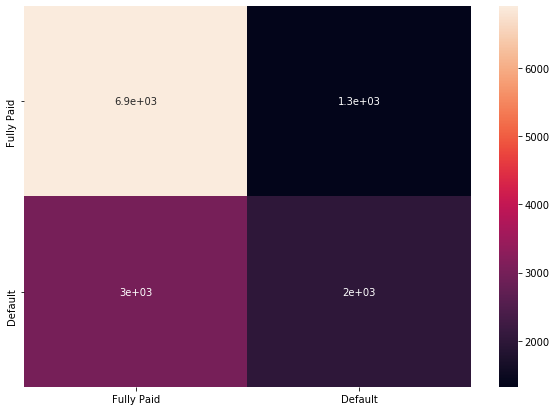

In [117]:
score = model_nn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred_nn), 
                      index = ['Fully Paid', 'Default'], 
                      columns = ['Fully Paid', 'Default'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [118]:
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

F1 Score: 0.4805459116485095
              precision    recall  f1-score   support

           0       0.70      0.84      0.76      8229
           1       0.60      0.40      0.48      5022

    accuracy                           0.67     13251
   macro avg       0.65      0.62      0.62     13251
weighted avg       0.66      0.67      0.65     13251



notes
higher f1 score is good.
we dont want a default to be labeled as a paid since this results in a larger loss of money
so we want to minimize false negative(label was predicted positive and is actually negative or predicted paid actually default)
so we want to look at recall
loook at the numbers for 1

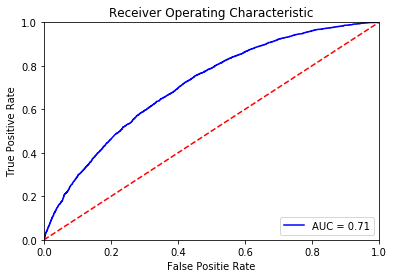

In [119]:
# predict probabilities
prob = model_nn.predict(x_test_nn)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate roc curve
fpr, tpr, threshold = roc_curve(y_test, preds)
# calculate auc, equivalent to roc_auc_score()?
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positie Rate')
plt.show()

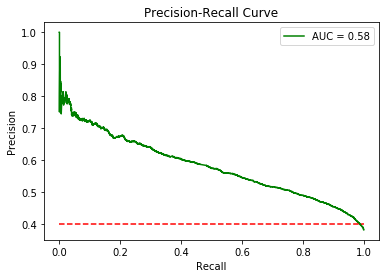

In [120]:
precision, recall, threshold = precision_recall_curve(y_test, preds)
roc_auc = auc(recall, precision)
plt.title('Precision-Recall Curve')
plt.plot(recall, precision, 'g', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'upper right')
plt.plot([0, 1], [0.4, 0.4], 'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [122]:
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority')
x_train_nn_sm, y_train_sm = smote.fit_sample(x_train_nn, y_train)
# class_weights = class_weight.compute_class_weight('balanced', 
#                                                   np.unique(y_train_sm), 
#                                                   y_train_sm)
model_nn.fit(x_train_nn_sm, to_categorical(y_train_sm), epochs=5, batch_size=10, verbose=0)
model_nn.save(str(Path('../data/model_nn2.h5')))
y_pred_nn = model_nn.predict_classes(x_test_nn)
score = model_nn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

c:\users\leon\miniconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13251/13251 [==============================] - 0s 21us/step
Accuracy: 64.53%
[[5199 3030]
 [1668 3354]]
F1 Score: 0.5881115202524987
              precision    recall  f1-score   support

           0       0.76      0.63      0.69      8229
           1       0.53      0.67      0.59      5022

    accuracy                           0.65     13251
   macro avg       0.64      0.65      0.64     13251
weighted avg       0.67      0.65      0.65     13251



In [123]:
from imblearn.over_sampling import ADASYN

x_train_nn_as, y_train_as = ADASYN(random_state=42).fit_sample(x_train_nn, y_train)
model_nn.fit(x_train_nn_as, to_categorical(y_train_as), epochs=5, batch_size=10, verbose=0)
model_nn.save(str(Path('../data/model_nn3.h5')))
y_pred_nn = model_nn.predict_classes(x_test_nn)
score = model_nn.evaluate(x_test_nn, to_categorical(y_test))
print("Accuracy: %.2f%%" % (score[1]*100))
print(confusion_matrix(y_test, y_pred_nn))
print('F1 Score:', f1_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

c:\users\leon\miniconda3\envs\aiml\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


13251/13251 [==============================] - 0s 21us/step
Accuracy: 63.71%
[[5018 3211]
 [1598 3424]]
F1 Score: 0.5874581796345544
              precision    recall  f1-score   support

           0       0.76      0.61      0.68      8229
           1       0.52      0.68      0.59      5022

    accuracy                           0.64     13251
   macro avg       0.64      0.65      0.63     13251
weighted avg       0.67      0.64      0.64     13251



### XGBoost Model

In [124]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', 
                                                  np.unique(y_train.values.ravel()), 
                                                  y_train.values.ravel())
model_xgb = XGBClassifier(scale_pos_weight=class_weights[1]) # random state?
model_xgb.fit(x_train, y_train.values.ravel())
y_pred_xgb = model_xgb.predict(x_test)

### XGBoost Results

Accuracy: 67.93%
[[5899 2330]
 [1920 3102]]


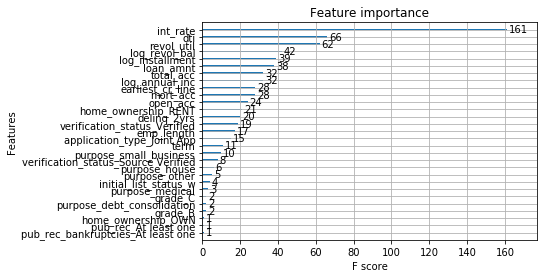

In [125]:
print("Accuracy: %.2f%%" % (model_xgb.score(x_test, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
plot_importance(model_xgb)
plt.show()

In [126]:
# from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score
# thresholds = np.sort(model_xgb.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model_xgb, threshold=thresh, prefit=True)
#     select_x_train = selection.transform(x_train)
#     # train model
#     selection_model = XGBClassifier(scale_pos_weight=class_weights[1])
#     selection_model.fit(select_x_train, y_train.values.ravel())
#     # eval model
#     select_x_test = selection.transform(x_test)
#     y_pred_xgb = selection_model.predict(select_x_test)
#     predictions = [round(value) for value in y_pred_xgb]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, 
#                                                   select_x_train.shape[1], 
#                                                   accuracy * 100))

Accuracy: 68.34%
[[5855 2374]
 [1821 3201]]


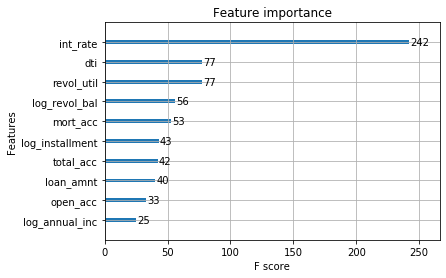

In [127]:
# Extract the ten most important features
model_path_xgb = Path('../data/model_xgb.joblib')
important_indices = ['dti', 
                     'int_rate',
                     'revol_util',
                     'log_installment', 
                     'open_acc', 
                     'log_revol_bal', 
                     'mort_acc', 
                     'loan_amnt', 
                     'total_acc',
                     'log_annual_inc']
x_train_xgb = x_train.loc[:, important_indices]
x_test_xgb = x_test.loc[:, important_indices]
if os.path.exists(model_path_xgb):
    model_xgb = load(model_path_xgb)
else:
    model_xgb = XGBClassifier(scale_pos_weight=class_weights[1])
    model_xgb.fit(x_train_xgb, y_train.values.ravel())
    dump(model_xgb, model_path_xgb)
y_pred_xgb = model_xgb.predict(x_test_xgb)
print("Accuracy: %.2f%%" % (model_xgb.score(x_test_xgb, y_test) * 100))
print(confusion_matrix(y_test, y_pred_xgb))
plot_importance(model_xgb)
plt.show()

### Support Vector Machine Model

In [128]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV

# model_svm_path = Path('../data/model_svm.joblib')
# if os.path.exists(model_svm_path):
#     model_svm = load(model_svm_path)
# else:            
#     # parameter_candidates = [
#     #     {'C': [1, 10, 100], 'kernel': ['linear'], 'class_weight': ['balanced']},        
#     #     {'C': [1, 10, 100], 'gamma': [10, 0, 0.001, 0.0001], 'kernel': ['rbf'], 'class_weight': ['balanced']}    
#     # ]
#     # 
#     # clf = GridSearchCV(estimator=SVC(), param_grid = parameter_candidates, n_jobs=-1, cv=5)
#     # clf.fit(x_train, y_train.values.ravel())
#     # print('Best score for data:', clf.best_score_)
#     # print('Best C:', clf.best_estimator_.C)
#     # print('Best Kernel:', clf.best_estimator_.kernel)
#     # print('Best Gamma:', clf.best_estimator_.gamma)
#     model_svm = SVC(kernel='rbf', C=1, gamma=0.05, class_weight='balanced', random_state=0)
#     model_svm.fit(x_train, y_train.values.ravel())
#     dump(model_svm, model_svm_path)
# y_pred_svm = model_svm.predict(x_test)
# print('Accuracy of SVM on test set: {:.3f}'.format(model_svm.score(x_test, y_test)))
# # 0.741 C=1 gamma = 0.05
# # 0.777 C=1 gamma = 1

In [129]:
# print("Accuracy: %.2f%%" % (model_svm.score(x_test, y_test) * 100))
# print(confusion_matrix(y_test, y_pred_svm))

### Ensembled Model

In [130]:
# Random Forest Model
output_rf = model_rf.predict_proba(x_test)
output_rf2 = y_pred_rf_i

# Neural Network Model
output_nn = model_nn.predict(x_test_nn)
output_nn2 = y_pred_nn

# XGBoost Model
output_xgb = model_xgb.predict_proba(x_test_xgb)
output_xgb2 = y_pred_xgb

# Ensemble output
# Avg
output = (output_rf + output_nn + output_xgb) / 3

# Majority vote
output2 = pd.DataFrame({'rf': output_rf2, 'nn': output_nn2, 'xgb': output_xgb2})
output2['Prediction'] = output2.sum(axis=1)
output2.loc[output2['Prediction'] < 2, 'Prediction'] = 0
output2.loc[output2['Prediction'] >= 2, 'Prediction'] = 1

### Ensembled Results

In [131]:
p_output = pd.DataFrame(output)
p_output.columns = ['Fully Paid', 'Default']
p_output['Prediction'] = p_output.idxmax(axis=1)
p_output['Fully Paid'] = p_output['Fully Paid'].multiply(100).round(0).astype(int).astype(str) + '%'
p_output['Default'] = p_output['Default'].multiply(100).round(0).astype(int).astype(str) + '%'
print(p_output.head())

y_test2 = pd.DataFrame(y_test)
y_test2.columns = ['Prediction']
y_test2['Prediction'].replace(0, 'Fully Paid', inplace=True)
y_test2['Prediction'].replace(1, 'Default', inplace=True)
accuracy = accuracy_score(y_true=y_test2, y_pred=p_output['Prediction'])
print("Accuracy: %.2f%%" % (accuracy * 100))

# Majority
output2['Prediction'].replace(0, 'Fully Paid', inplace=True)
output2['Prediction'].replace(1, 'Default', inplace=True)
print("\n", output2.head())

accuracy = accuracy_score(y_true=y_test2, y_pred=output2['Prediction'])
print("Accuracy: %.2f%%" % (accuracy * 100))

  Fully Paid Default  Prediction
0        63%     37%  Fully Paid
1        35%     65%     Default
2        52%     48%  Fully Paid
3        43%     57%     Default
4        41%     59%     Default
Accuracy: 67.21%

    rf  nn  xgb  Prediction
0   0   0    0  Fully Paid
1   1   1    1     Default
2   1   1    0     Default
3   1   1    1     Default
4   1   1    0     Default
Accuracy: 66.49%


In [137]:
# predict probabilities
pos_pred_rf = model_rf.predict_proba(x_test)
pos_pred_nn = model_nn.predict(x_test_nn)
# keep probabilities for the positive outcome only
pos_pred_rf = pos_pred_rf[:,1]
pos_pred_nn = pos_pred_nn[:,1]
print(pos_pred_rf)
print(pos_pred_nn)
# calculate roc curve
fpr_rf, tpr_rf, threshold = roc_curve(y_test, pos_pred_rf)
fpr_nn, tpr_nn, threshold = roc_curve(y_test, pos_pred_nn)
# # calculate auc, equivalent to roc_auc_score()?
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'r', label = 'RF AUC = %0.2f' % roc_auc_rf)
plt.plot(fpr_nn, tpr_nn, 'b', label = 'NN AUC = %0.2f' % roc_auc_nn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positie Rate')
plt.show()

ValueError: Data is not binary and pos_label is not specified